<a href="https://colab.research.google.com/github/KaiserKyle/IST-718-Final-Project/blob/master/Data_Analysis_Who's_In.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  # 2D plotting
from matplotlib.cbook import boxplot_stats
import seaborn as sns 

In [98]:
from keras.utils.np_utils import to_categorical   

data = pd.read_csv('https://raw.githubusercontent.com/KaiserKyle/IST-718-Final-Project/master/agg_team_stats.csv' ,low_memory=False)
data = data.drop(['name', 'market', 'alias','conf_id','division_alias','conf_name'], axis=1)
data['win_perc'] = data.Win / (data.Win + data.Loss)
data = data.drop(['Win','Loss'], axis = 1)
data.fillna(0, inplace=True)
conf_encode = pd.get_dummies(data['conf_alias'])
data = pd.concat([data, conf_encode], axis = 1)
data.head()

,season,team_id,conf_alias,points_game,field_goals_made,field_goals_att,field_goals_pct,three_points_made,three_points_att,three_points_pct,two_points_made,two_points_att,two_points_pct,blocked_att,free_throws_made,free_throws_att,free_throws_pct,offensive_rebounds,defensive_rebounds,rebounds,assists,turnovers,steals,blocks,assists_turnover_ratio,personal_fouls,ejections,foulouts,points,fast_break_pts,second_chance_pts,team_turnovers,points_off_turnovers,team_rebounds,flagrant_fouls,player_tech_fouls,team_tech_fouls,coach_tech_fouls,NCAA,Conference,Conference_Champ,win_perc,A10,AAC,ACC,AE,AS,BIG10,BIG12,BIGEAST,BIGSKY,BIGSOUTH,BIGWEST,COLONIAL,CUSA,HORIZON,IVY,MAAC,MAC,MEAC,MVC,MWC,NE,OVC,PAC12,PATRIOT,SEC,SOUTHERN,SOUTHLAND,SUMMIT,SUNBELT,SWAC,WAC,WCC
0,2013,8ddbfca9-a931-4908-aa31-9fcd17624b5f,CUSA,71.451613,22.25,60.500000,36.750000,5.500000,16.000000,34.875000,16.750000,44.5,37.650000,5.000000,12.000000,18.250000,64.850000,13.500000,23.000000,36.500000,10.250000,15.000000,6.000000,2.250000,0.782500,18.750000,0.0,2.0,62.000000,5.000000,10.000000,0.750000,10.750000,3.000000,0.000000,0.75,0.0,0.0,False,True,False,0.387097,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2013,11a617d5-af03-4cce-bc8a-51114d9e41fe,BIGWEST,69.741935,23.20,59.200000,38.830000,5.400000,19.600000,27.410000,17.800000,39.6,44.050000,2.900000,11.000000,17.900000,59.790000,10.500000,19.300000,29.800000,11.000000,11.900000,5.400000,2.000000,0.989000,18.400000,0.0,0.0,62.800000,6.555556,10.600000,0.300000,10.900000,3.900000,0.000000,0.00,0.0,0.0,False,True,False,0.354839,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2013,d8217105-e9c2-4267-9538-3aaeea1ae167,MVC,69.393939,22.00,53.333333,41.650000,4.666667,13.333333,35.916667,17.333333,40.0,43.733333,5.333333,11.000000,17.166667,65.500000,5.666667,21.666667,27.333333,13.333333,13.833333,4.333333,3.666667,1.013333,21.333333,0.0,0.0,59.666667,5.500000,6.833333,0.400000,7.666667,4.800000,0.166667,0.00,0.0,0.0,False,True,False,0.303030,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2013,5016fe1a-9571-4d10-bf5b-b9c1b496bd57,WAC,77.000000,22.00,56.666667,38.333333,4.333333,14.666667,28.266667,17.666667,42.0,41.733333,5.666667,13.333333,20.000000,66.466667,10.000000,17.333333,27.333333,11.333333,13.000000,5.333333,4.000000,0.920000,17.333333,0.0,0.0,61.666667,6.000000,10.000000,0.333333,17.000000,3.666667,0.333333,0.00,0.0,0.0,True,True,True,0.277778,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,2013,53aaac6a-796e-41a6-a04e-6ce74c5717f8,MEAC,65.281250,16.00,48.500000,32.750000,7.000000,19.500000,34.500000,9.000000,29.0,31.200000,0.500000,21.500000,30.000000,71.800000,8.500000,22.500000,31.000000,12.000000,16.000000,2.500000,3.000000,0.790000,26.500000,0.0,0.0,60.500000,7.000000,7.000000,1.500000,3.500000,4.500000,0.000000,0.00,0.0,0.0,False,True,False,0.218750,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


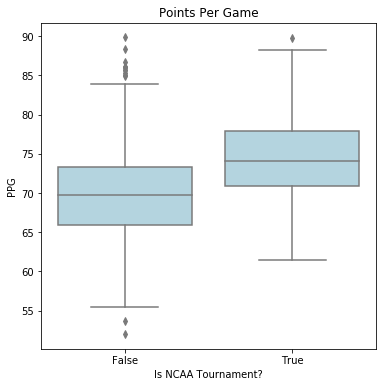

In [0]:
plt.rcParams['figure.figsize'] = [6, 6]
g = sns.boxplot(x="NCAA", y="points_game", data=data, color = "lightblue")
g.set(xlabel = "Is NCAA Tournament?", ylabel = "PPG")
g.set_title("Points Per Game")

plt.show()

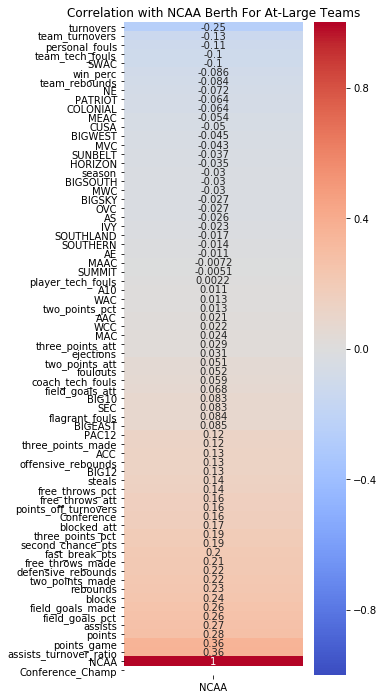

In [99]:
at_large_data = data[data.Conference_Champ == False]

plt.rcParams['figure.figsize'] = [4, 12]
corr = at_large_data.corr()
corr = corr.loc[['NCAA']].transpose().sort_values(by = 'NCAA')
g = sns.heatmap(corr, 
            yticklabels=corr.index.values,
            annot = True,
            center = 0,
            vmin = -1,
            vmax = 1,
            cmap = 'coolwarm')

plt.title("Correlation with NCAA Berth For At-Large Teams")

plt.show()

In [100]:
train_data = at_large_data[(at_large_data['season'] == 2013) | (at_large_data['season'] == 2014) | (at_large_data['season'] == 2015)]
test_data = at_large_data[(at_large_data['season'] == 2016) | (at_large_data['season'] == 2017)]

y_test = test_data[['NCAA', 'season', 'team_id']]
y_train = train_data[['NCAA', 'season', 'team_id']]
X_test = test_data.drop(['NCAA', 'season', 'team_id', 'conf_alias'], axis=1)
X_train = train_data.drop(['NCAA', 'season', 'team_id', 'conf_alias'], axis=1)

X_train.head()

,points_game,field_goals_made,field_goals_att,field_goals_pct,three_points_made,three_points_att,three_points_pct,two_points_made,two_points_att,two_points_pct,blocked_att,free_throws_made,free_throws_att,free_throws_pct,offensive_rebounds,defensive_rebounds,rebounds,assists,turnovers,steals,blocks,assists_turnover_ratio,personal_fouls,ejections,foulouts,points,fast_break_pts,second_chance_pts,team_turnovers,points_off_turnovers,team_rebounds,flagrant_fouls,player_tech_fouls,team_tech_fouls,coach_tech_fouls,Conference,Conference_Champ,win_perc,A10,AAC,ACC,AE,AS,BIG10,BIG12,BIGEAST,BIGSKY,BIGSOUTH,BIGWEST,COLONIAL,CUSA,HORIZON,IVY,MAAC,MAC,MEAC,MVC,MWC,NE,OVC,PAC12,PATRIOT,SEC,SOUTHERN,SOUTHLAND,SUMMIT,SUNBELT,SWAC,WAC,WCC
0,71.451613,22.250000,60.500000,36.750000,5.500000,16.000000,34.875000,16.750000,44.500000,37.650000,5.000000,12.000000,18.250000,64.850000,13.500000,23.000000,36.500000,10.250000,15.000000,6.000000,2.250000,0.782500,18.750000,0.0,2.0,62.000000,5.000000,10.000000,0.750000,10.750000,3.0,0.000000,0.750000,0.0,0.0,True,False,0.387097,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,69.741935,23.200000,59.200000,38.830000,5.400000,19.600000,27.410000,17.800000,39.600000,44.050000,2.900000,11.000000,17.900000,59.790000,10.500000,19.300000,29.800000,11.000000,11.900000,5.400000,2.000000,0.989000,18.400000,0.0,0.0,62.800000,6.555556,10.600000,0.300000,10.900000,3.9,0.000000,0.000000,0.0,0.0,True,False,0.354839,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,69.393939,22.000000,53.333333,41.650000,4.666667,13.333333,35.916667,17.333333,40.000000,43.733333,5.333333,11.000000,17.166667,65.500000,5.666667,21.666667,27.333333,13.333333,13.833333,4.333333,3.666667,1.013333,21.333333,0.0,0.0,59.666667,5.500000,6.833333,0.400000,7.666667,4.8,0.166667,0.000000,0.0,0.0,True,False,0.303030,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,65.281250,16.000000,48.500000,32.750000,7.000000,19.500000,34.500000,9.000000,29.000000,31.200000,0.500000,21.500000,30.000000,71.800000,8.500000,22.500000,31.000000,12.000000,16.000000,2.500000,3.000000,0.790000,26.500000,0.0,0.0,60.500000,7.000000,7.000000,1.500000,3.500000,4.5,0.000000,0.000000,0.0,0.0,True,False,0.218750,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,64.676471,22.764706,53.558824,42.638235,5.794118,18.264706,31.802941,16.970588,35.294118,48.376471,3.676471,13.352941,20.794118,65.426471,8.147059,22.676471,30.823529,12.911765,11.117647,6.352941,3.823529,1.286471,17.911765,0.0,0.0,64.676471,7.100000,8.176471,0.242424,13.147059,3.0,0.029412,0.117647,0.0,0.0,True,False,0.205882,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [101]:
from sklearn import linear_model
clf = linear_model.SGDClassifier(max_iter=1000)
clf.fit(X_train, y_train.NCAA)
clf.score(X_test, y_test.NCAA)

0.6542056074766355

In [102]:
from sklearn.svm import SVC
clf = SVC()
clf.fit(X_train, y_train.NCAA)
clf.score(X_test, y_test.NCAA)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.7040498442367601

In [103]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train.NCAA)
neigh.score(X_test, y_test.NCAA)

0.6246105919003115

In [104]:
from sklearn.ensemble import RandomForestClassifier 

forest = RandomForestClassifier(n_estimators = 500)
forest.fit(X_train, y_train.NCAA)
print('Random Forest Score: ', forest.score(X_test, y_test.NCAA))

predictions = pd.DataFrame(forest.predict_proba(X_test))

predictions['Actual'] = y_test.NCAA.values
predictions['Season'] = y_test.season.values
predictions.sort_values(by = 1, ascending = False, inplace = True)

pred_2016 = predictions[predictions['Season'] == 2016]
pred_2017 = predictions[predictions['Season'] == 2017]

in_2016 = pred_2016.head(36)
in_2017 = pred_2017.head(36)

print("2016 Top 36 at-large bid accuracy: ", in_2016.Actual.mean())
print("2017 Top 36 at-large bid accuracy: ", in_2017.Actual.mean())

Random Forest Score:  0.7461059190031153
2016 Top 36 at-large bid accuracy:  0.8333333333333334
2017 Top 36 at-large bid accuracy:  0.8888888888888888


In [136]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler

print(X_train.shape)

def create_baseline():
	# create model
  model = Sequential()
  model.add(Dense(70, input_dim=70, kernel_initializer='normal', activation='relu'))
  model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
	# Compile model
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scale = scaler.transform(X_train)
X_test_scale = scaler.transform(X_test)

X_train_scale

(967, 70)


array([[ 0.23709944, -0.44147565,  0.77156113, ..., -0.1694798 ,
        -0.14899239, -0.1694798 ],
       [-0.06815018, -0.14690497,  0.55726456, ..., -0.1694798 ,
        -0.14899239, -0.1694798 ],
       [-0.13028218, -0.51899426, -0.40981742, ..., -0.1694798 ,
        -0.14899239, -0.1694798 ],
       ...,
       [ 1.04917864,  0.77298241,  0.8869516 , ..., -0.1694798 ,
         6.71175231, -0.1694798 ],
       [ 0.5581875 ,  0.97969868,  0.6479285 , ..., -0.1694798 ,
        -0.14899239, -0.1694798 ],
       [ 1.16140519,  0.73016262,  0.74094734, ..., -0.1694798 ,
        -0.14899239, -0.1694798 ]])

In [140]:
%%time

model = create_baseline()

# FIT THE MODEL
history  = model.fit(X_train_scale, y_train.NCAA, validation_data=(X_test_scale, y_test.NCAA), epochs=500, batch_size=1000, verbose=2)

# EVALUATE THE MODEL
scores = model.evaluate(X_test_scale, y_test.NCAA, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))


Train on 967 samples, validate on 642 samples
Epoch 1/500
 - 2s - loss: 0.6807 - acc: 0.6153 - val_loss: 0.6865 - val_acc: 0.5654
Epoch 2/500
 - 0s - loss: 0.6763 - acc: 0.6453 - val_loss: 0.6829 - val_acc: 0.5935
Epoch 3/500
 - 0s - loss: 0.6713 - acc: 0.6711 - val_loss: 0.6792 - val_acc: 0.6168
Epoch 4/500
 - 0s - loss: 0.6661 - acc: 0.6980 - val_loss: 0.6754 - val_acc: 0.6293
Epoch 5/500
 - 0s - loss: 0.6609 - acc: 0.7053 - val_loss: 0.6716 - val_acc: 0.6449
Epoch 6/500
 - 0s - loss: 0.6557 - acc: 0.7218 - val_loss: 0.6678 - val_acc: 0.6558
Epoch 7/500
 - 0s - loss: 0.6506 - acc: 0.7260 - val_loss: 0.6641 - val_acc: 0.6636
Epoch 8/500
 - 0s - loss: 0.6455 - acc: 0.7260 - val_loss: 0.6603 - val_acc: 0.6729
Epoch 9/500
 - 0s - loss: 0.6405 - acc: 0.7353 - val_loss: 0.6567 - val_acc: 0.6729
Epoch 10/500
 - 0s - loss: 0.6356 - acc: 0.7373 - val_loss: 0.6530 - val_acc: 0.6776
Epoch 11/500
 - 0s - loss: 0.6308 - acc: 0.7456 - val_loss: 0.6495 - val_acc: 0.6822
Epoch 12/500
 - 0s - loss: 0

In [141]:
y_hat = model.predict_proba(X_test_scale)

predictions = pd.DataFrame(y_hat)

predictions['Actual'] = y_test.NCAA.values
predictions['Season'] = y_test.season.values
predictions['Team'] = y_test.team_id.values

predictions.sort_values(by = 0, ascending = False, inplace = True)

#print(predictions.head(75))

pred_2016 = predictions[predictions['Season'] == 2016]
pred_2017 = predictions[predictions['Season'] == 2017]

in_2016 = pred_2016.head(36)
in_2017 = pred_2017.head(36)

print("2016 Top 36 at-large bid accuracy: ", in_2016.Actual.mean())
print("2017 Top 36 at-large bid accuracy: ", in_2017.Actual.mean())

2016 Top 36 at-large bid accuracy:  0.7777777777777778
2017 Top 36 at-large bid accuracy:  0.7222222222222222
